### 1. 필요한 라이브러리 불러오기

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

### 2. 전처리한 데이터 불러오기 및 데이터 확인

In [62]:
df = pd.read_csv('./data/result_final.csv', parse_dates=['baseYmd'])
df

,areaNm,touNum,baseYmd,avgTemp,dayRf,daySf,festival,holiday,PM10,PM25,AccumulateCovid19,increase,localIncrease,CovidForeigner
0,서울특별시,1171117.50,2022-01-01,-4.3,0.0,0.0,no,yes,no,no,226698.0,1464.0,1429.0,35.0
1,부산광역시,445102.00,2022-01-01,1.9,0.0,0.0,no,yes,no,no,25287.0,212.0,210.0,2.0
2,대구광역시,264113.50,2022-01-01,-2.3,0.0,0.0,no,yes,no,no,23249.0,125.0,125.0,0.0
3,인천광역시,496692.00,2022-01-01,-3.4,0.0,0.0,no,yes,no,no,36962.0,241.0,239.0,2.0
4,광주광역시,161028.00,2022-01-01,-0.1,0.0,0.0,no,yes,no,no,8118.0,92.0,91.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6200,전라북도,221235.00,2022-09-03,25.3,0.0,0.0,yes,yes,no,no,788103.0,3442.0,3431.0,11.0
6201,전라남도,304470.25,2022-09-03,24.1,0.5,0.0,yes,yes,no,no,776823.0,3048.0,3041.0,7.0
6202,경상북도,425582.50,2022-09-03,21.0,0.1,0.0,no,yes,no,no,1042687.0,4782.0,4753.0,29.0
6203,경상남도,363550.25,2022-09-03,21.0,6.6,0.0,no,yes,no,no,1406209.0,5373.0,5362.0,11.0


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6205 entries, 0 to 6204
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   areaNm             6205 non-null   object        
 1   touNum             6205 non-null   float64       
 2   baseYmd            6205 non-null   datetime64[ns]
 3   avgTemp            6205 non-null   float64       
 4   dayRf              6205 non-null   float64       
 5   daySf              6205 non-null   float64       
 6   festival           6205 non-null   object        
 7   holiday            6205 non-null   object        
 8   PM10               6205 non-null   object        
 9   PM25               6205 non-null   object        
 10  AccumulateCovid19  6205 non-null   float64       
 11  increase           6205 non-null   float64       
 12  localIncrease      6205 non-null   float64       
 13  CovidForeigner     6205 non-null   float64       
dtypes: datet

In [64]:
# 범주형변수 정규화
df_festival = pd.get_dummies(df['festival'], prefix='festival')
df = pd.concat([df, df_festival], axis=1)
df_holiday = pd.get_dummies(df['holiday'], prefix='holiday')
df = pd.concat([df, df_holiday], axis=1)
df_PM10 = pd.get_dummies(df['PM10'], prefix='PM10')
df = pd.concat([df, df_PM10], axis=1)
df_PM25 = pd.get_dummies(df['PM25'], prefix='PM25')
df = pd.concat([df, df_PM25], axis=1)
df.drop(columns=['festival', 'holiday', 'PM10', 'PM25'], inplace=True)
df

,areaNm,touNum,baseYmd,avgTemp,dayRf,daySf,AccumulateCovid19,increase,localIncrease,CovidForeigner,festival_no,festival_yes,holiday_no,holiday_yes,PM10_no,PM10_yes,PM25_no,PM25_yes
0,서울특별시,1171117.50,2022-01-01,-4.3,0.0,0.0,226698.0,1464.0,1429.0,35.0,1,0,0,1,1,0,1,0
1,부산광역시,445102.00,2022-01-01,1.9,0.0,0.0,25287.0,212.0,210.0,2.0,1,0,0,1,1,0,1,0
2,대구광역시,264113.50,2022-01-01,-2.3,0.0,0.0,23249.0,125.0,125.0,0.0,1,0,0,1,1,0,1,0
3,인천광역시,496692.00,2022-01-01,-3.4,0.0,0.0,36962.0,241.0,239.0,2.0,1,0,0,1,1,0,1,0
4,광주광역시,161028.00,2022-01-01,-0.1,0.0,0.0,8118.0,92.0,91.0,1.0,1,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6200,전라북도,221235.00,2022-09-03,25.3,0.0,0.0,788103.0,3442.0,3431.0,11.0,0,1,0,1,1,0,1,0
6201,전라남도,304470.25,2022-09-03,24.1,0.5,0.0,776823.0,3048.0,3041.0,7.0,0,1,0,1,1,0,1,0
6202,경상북도,425582.50,2022-09-03,21.0,0.1,0.0,1042687.0,4782.0,4753.0,29.0,1,0,0,1,1,0,1,0
6203,경상남도,363550.25,2022-09-03,21.0,6.6,0.0,1406209.0,5373.0,5362.0,11.0,1,0,0,1,1,0,1,0


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6205 entries, 0 to 6204
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   areaNm             6205 non-null   object        
 1   touNum             6205 non-null   float64       
 2   baseYmd            6205 non-null   datetime64[ns]
 3   avgTemp            6205 non-null   float64       
 4   dayRf              6205 non-null   float64       
 5   daySf              6205 non-null   float64       
 6   AccumulateCovid19  6205 non-null   float64       
 7   increase           6205 non-null   float64       
 8   localIncrease      6205 non-null   float64       
 9   CovidForeigner     6205 non-null   float64       
 10  festival_no        6205 non-null   uint8         
 11  festival_yes       6205 non-null   uint8         
 12  holiday_no         6205 non-null   uint8         
 13  holiday_yes        6205 non-null   uint8         
 14  PM10_no 

In [66]:
df.columns

Index(['areaNm', 'touNum', 'baseYmd', 'avgTemp', 'dayRf', 'daySf',
       'AccumulateCovid19', 'increase', 'localIncrease', 'CovidForeigner',
       'festival_no', 'festival_yes', 'holiday_no', 'holiday_yes', 'PM10_no',
       'PM10_yes', 'PM25_no', 'PM25_yes'],
      dtype='object')

In [71]:
df_col = df.drop(columns=['areaNm', 'localIncrease', 'CovidForeigner', 'baseYmd', 'festival_no', 'festival_yes', 'holiday_no', 'holiday_yes',
       'festival_no', 'festival_yes', 'holiday_no', 'holiday_yes', 'PM10_no',
       'PM10_yes', 'PM25_no', 'PM25_yes'])

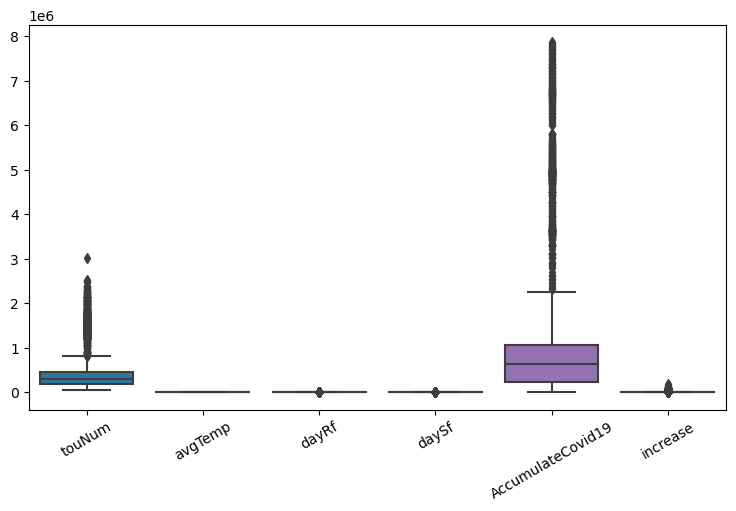

In [72]:
# 스케일링 전
plt.figure(figsize=(9, 5))
df_box = sns.boxplot(data=df_col)
df_box.set_xticklabels(df_box.get_xticklabels(), rotation=30)
plt.show()

In [73]:
# 이상치 대체 함수
def replace_outliers_median(data, threshold=1):
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    data[z_scores >= threshold] = np.median(data)
    return data


In [12]:
# df_col = replace_outliers_median(df_col)

In [13]:
# # 이상치 대체
# plt.figure(figsize=(9, 5))
# df_box3 = sns.boxplot(data=df_col)
# df_box3.set_xticklabels(df_box3.get_xticklabels(), rotation=30)
# plt.show()

In [74]:
scaler = RobustScaler()
df_scaling = scaler.fit_transform(df_col)
df_scaled = pd.DataFrame(df_scaling, columns=df_col.columns)
df_scaled

,touNum,avgTemp,dayRf,daySf,AccumulateCovid19,increase
0,3.455394,-1.118343,0.0,0.0,-0.500057,-0.082879
1,0.560710,-0.751479,0.0,0.0,-0.743523,-0.424209
2,-0.160906,-1.000000,0.0,0.0,-0.745986,-0.447928
3,0.766404,-1.065089,0.0,0.0,-0.729410,-0.416303
4,-0.571916,-0.869822,0.0,0.0,-0.764277,-0.456925
...,...,...,...,...,...,...
6200,-0.331866,0.633136,0.0,0.0,0.178569,0.456379
6201,0.000000,0.562130,5.0,0.0,0.164933,0.348964
6202,0.482884,0.378698,1.0,0.0,0.486310,0.821701
6203,0.235557,0.378698,66.0,0.0,0.925735,0.982824


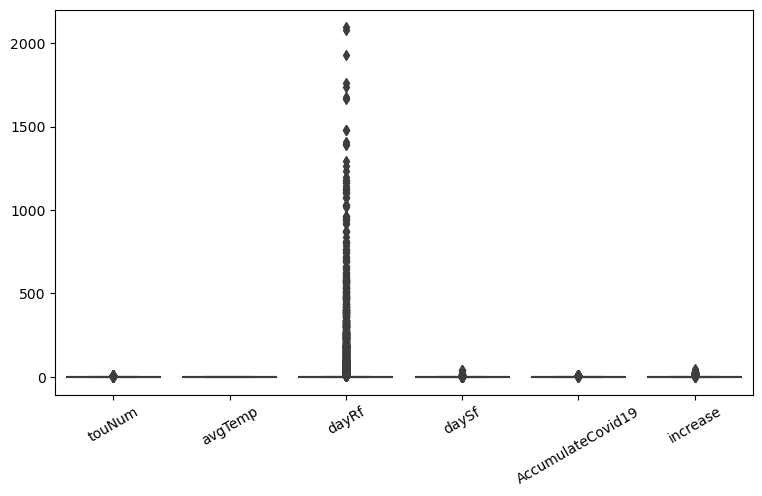

In [75]:
# 스케일링 후
plt.figure(figsize=(9, 5))
df_box2 = sns.boxplot(data=df_scaled)
df_box2.set_xticklabels(df_box2.get_xticklabels(), rotation=30)
plt.show()

In [76]:
df_drop = df.drop(columns= ['touNum', 'avgTemp', 'dayRf', 'daySf', 'AccumulateCovid19', 'increase', 'localIncrease', 'CovidForeigner'])

In [77]:
df = pd.concat([df_drop, df_col], axis=1)
df.to_csv('./data/df_final.csv', index=False, encoding='utf-8')
df

,areaNm,baseYmd,festival_no,festival_yes,holiday_no,holiday_yes,PM10_no,PM10_yes,PM25_no,PM25_yes,touNum,avgTemp,dayRf,daySf,AccumulateCovid19,increase
0,서울특별시,2022-01-01,1,0,0,1,1,0,1,0,1171117.50,-4.3,0.0,0.0,226698.0,1464.0
1,부산광역시,2022-01-01,1,0,0,1,1,0,1,0,445102.00,1.9,0.0,0.0,25287.0,212.0
2,대구광역시,2022-01-01,1,0,0,1,1,0,1,0,264113.50,-2.3,0.0,0.0,23249.0,125.0
3,인천광역시,2022-01-01,1,0,0,1,1,0,1,0,496692.00,-3.4,0.0,0.0,36962.0,241.0
4,광주광역시,2022-01-01,1,0,0,1,1,0,1,0,161028.00,-0.1,0.0,0.0,8118.0,92.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6200,전라북도,2022-09-03,0,1,0,1,1,0,1,0,221235.00,25.3,0.0,0.0,788103.0,3442.0
6201,전라남도,2022-09-03,0,1,0,1,1,0,1,0,304470.25,24.1,0.5,0.0,776823.0,3048.0
6202,경상북도,2022-09-03,1,0,0,1,1,0,1,0,425582.50,21.0,0.1,0.0,1042687.0,4782.0
6203,경상남도,2022-09-03,1,0,0,1,1,0,1,0,363550.25,21.0,6.6,0.0,1406209.0,5373.0


### 3. 임의의 지역을 각각의 샘플로 저장

In [78]:
# 분류하여 각 변수에 저장
df_seoul = df.loc[df['areaNm'] == '서울특별시']
df_jeju = df.loc[df['areaNm'] == '제주특별자치도']
df_gangwon = df.loc[df['areaNm'] == '강원도']
df_jeonju = df.loc[df['areaNm'] == '전라남도']
df_busan = df.loc[df['areaNm'] == '부산광역시']
df_chungju = df.loc[df['areaNm'] == '충청북도']


In [79]:
# 분류된 광역시 컬럼 삭제
df_seoul.drop(columns=['areaNm'], inplace=True)
df_jeju.drop(columns=['areaNm'], inplace=True)
df_gangwon.drop(columns=['areaNm'], inplace=True)
df_jeonju.drop(columns=['areaNm'], inplace=True)
df_busan.drop(columns=['areaNm'], inplace=True)
df_chungju.drop(columns=['areaNm'], inplace=True)

### 4. 각 샘플 데이터 확인

- 서울특별시

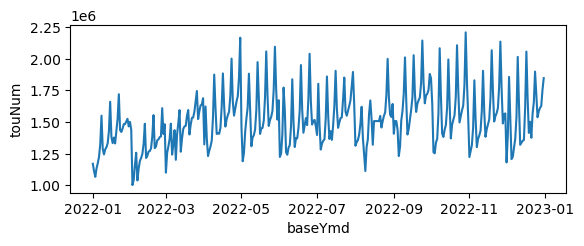

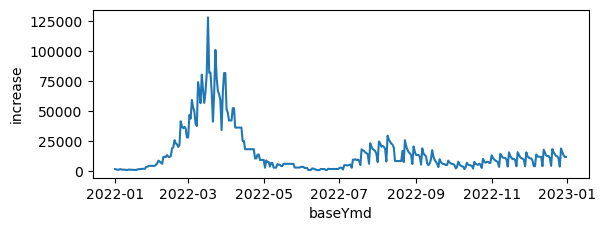

In [80]:
# 일별 관광객 그래프
plt.subplot(2,1,1)
sns.lineplot(x=df_seoul['baseYmd'], y=df_seoul['touNum'])
plt.show()

# 일별 확진자 그래프
plt.subplot(2,1,2)
sns.lineplot(x=df_seoul['baseYmd'], y=df_seoul['increase'])
plt.show()

- 제주특별자치도

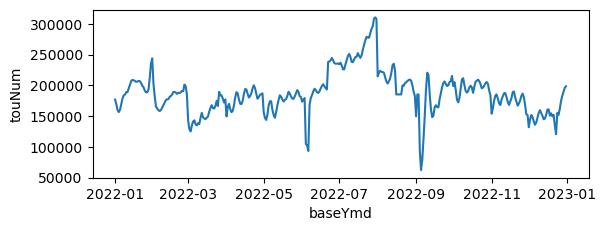

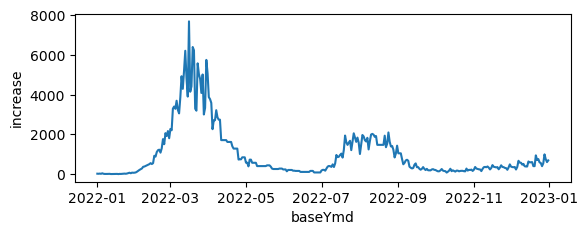

In [21]:
# 일별 관광객 그래프
plt.subplot(2,1,1)
sns.lineplot(x=df_jeju['baseYmd'], y=df_jeju['touNum'])
plt.show()

# 일별 확진자 그래프
plt.subplot(2,1,2)
sns.lineplot(x=df_jeju['baseYmd'], y=df_jeju['increase'])
plt.show()

- 강원도

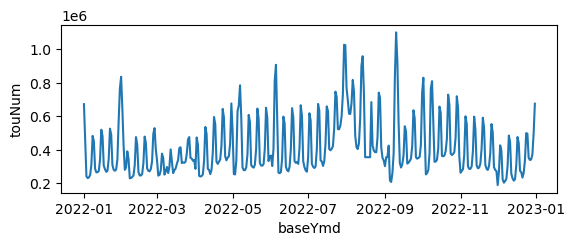

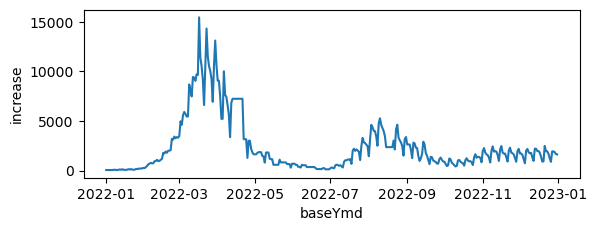

In [22]:
# 일별 관광객 그래프
plt.subplot(2,1,1)
sns.lineplot(x=df_gangwon['baseYmd'], y=df_gangwon['touNum'])
plt.show()

# 일별 확진자 그래프
plt.subplot(2,1,2)
sns.lineplot(x=df_gangwon['baseYmd'], y=df_gangwon['increase'])
plt.show()

- 전라남도

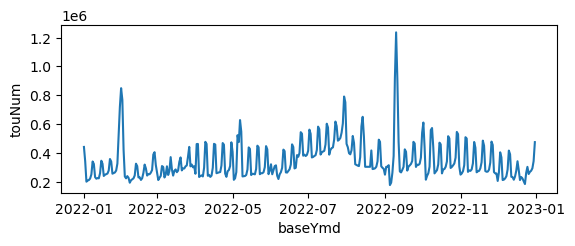

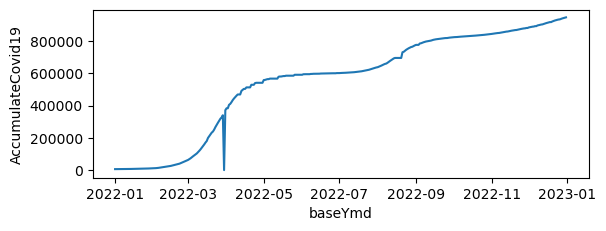

In [36]:
# 일별 관광객 그래프
plt.subplot(2,1,1)
sns.lineplot(x=df_jeonju['baseYmd'], y=df_jeonju['touNum'])
plt.show()

# 일별 확진자 그래프
plt.subplot(2,1,2)
sns.lineplot(x=df_jeonju['baseYmd'], y=df_jeonju['increase'])
plt.show()

- 부산광역시

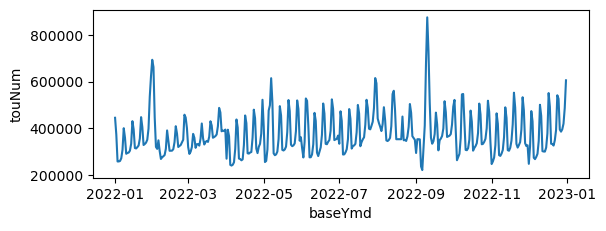

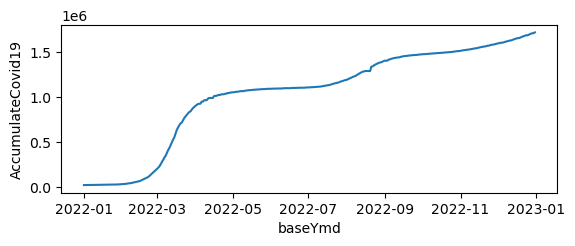

In [35]:
# 일별 관광객 그래프
plt.subplot(2,1,1)
sns.lineplot(x=df_busan['baseYmd'], y=df_busan['touNum'])
plt.show()

# 일별 확진자 그래프
plt.subplot(2,1,2)
sns.lineplot(x=df_busan['baseYmd'], y=df_busan['increase'])
plt.show()

- 충청북도

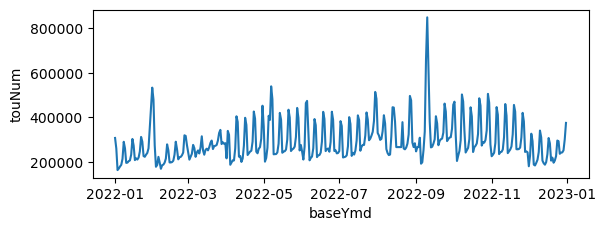

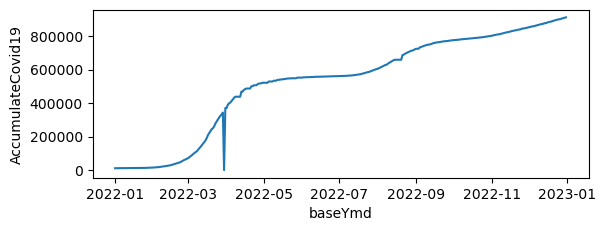

In [34]:
# 일별 관광객 그래프
plt.subplot(2,1,1)
sns.lineplot(x=df_chungju['baseYmd'], y=df_chungju['touNum'])
plt.show()

# 일별 확진자 그래프
plt.subplot(2,1,2)
sns.lineplot(x=df_chungju['baseYmd'], y=df_chungju['increase'])
plt.show()

### 5. 가설검정 (서울특별시, 제주특별자치도)

- 귀무가설 : 해외여행을 못 가게 되었지만, 코로나의 위험성에 국내 여행을 자제할 것이다.

- 대립가설 : 해외여행을 못 가게 된 사람들이 국내 여행을 많이 찾게 되면서 코로나 추세와는 상관없이 관광객이 많을 것이다.

- 서울특별시

<AxesSubplot:>

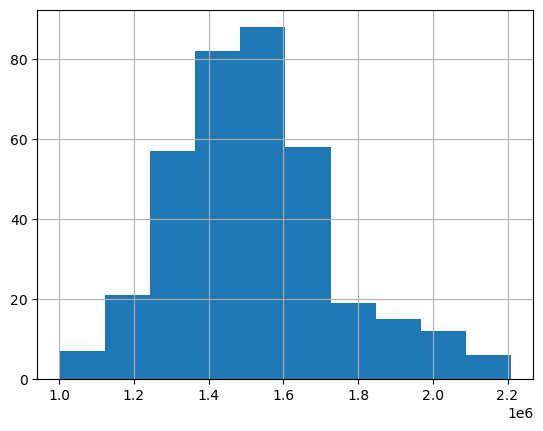

In [ ]:
# 관광객수(정규분포)
df_seoul['touNum'].hist()

<AxesSubplot:>

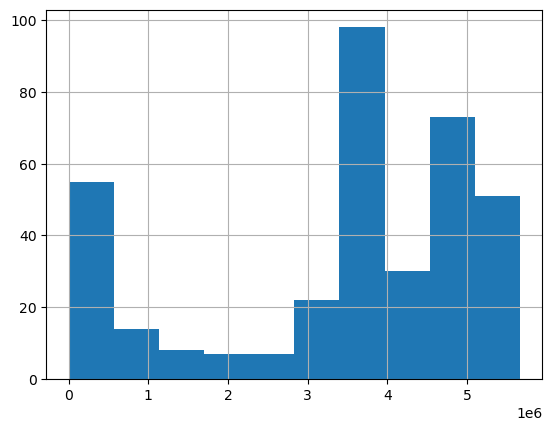

In [ ]:
# 누적확진자수(비정규분포)
df_seoul['AccumulateCovid19'].hist()

In [81]:
df_seoul.columns

Index(['baseYmd', 'festival_no', 'festival_yes', 'holiday_no', 'holiday_yes',
       'PM10_no', 'PM10_yes', 'PM25_no', 'PM25_yes', 'touNum', 'avgTemp',
       'dayRf', 'daySf', 'AccumulateCovid19', 'increase'],
      dtype='object')

In [82]:
# 독립변수와 종속변수 나누어 저장
dfX_seoul = df_seoul.drop(columns=['touNum', 'baseYmd'])
dfy_seoul = df_seoul.drop(columns=['baseYmd', 'festival_no', 'festival_yes', 'holiday_no', 'holiday_yes',
       'festival_no', 'festival_yes', 'holiday_no', 'holiday_yes', 'PM10_no', 'dayRf', 'daySf',
       'PM10_yes', 'PM25_no', 'PM25_yes', 'avgTemp', 'AccumulateCovid19', 'increase'])

In [83]:
dfXy_seoul = pd.concat([dfX_seoul, dfy_seoul], axis=1)

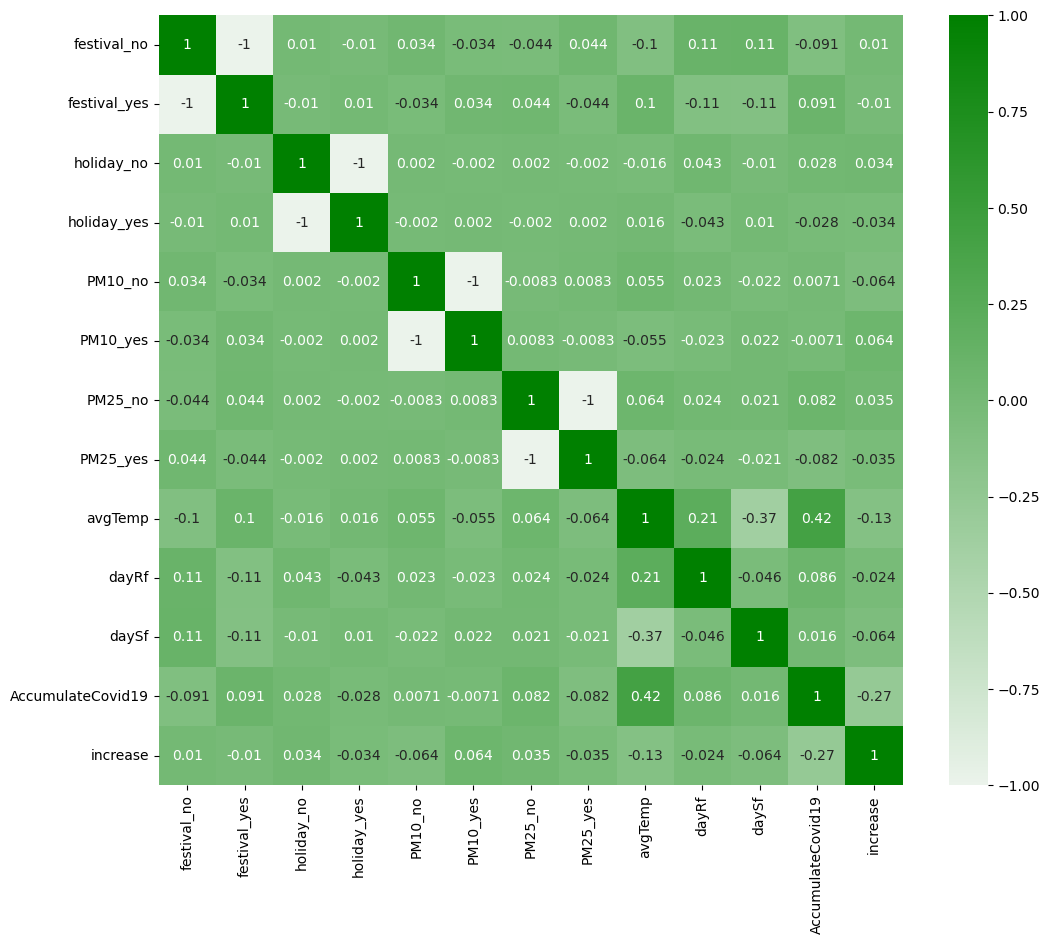

In [84]:
plt.figure(figsize=(12, 10))
cmap = sns.light_palette("green", as_cmap=True)
sns.heatmap(dfX_seoul.corr(), annot=True, cmap=cmap)
plt.show()

In [85]:
# 서울특별시 다중공선성 조사
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(dfX_seoul.values, i) for i in range(dfX_seoul.shape[1])]
vif["변수"] = dfX_seoul.columns
vif = vif.sort_values("VIF").reset_index(drop=True)
vif

,VIF,변수
0,1.069201,dayRf
1,1.096345,increase
2,1.229156,daySf
3,1.344920,AccumulateCovid19
4,1.536574,avgTemp
5,inf,festival_no
6,inf,festival_yes
7,inf,holiday_no
8,inf,holiday_yes
9,inf,PM10_no


In [88]:
# 학습용 7 : 검증용 3 dayRf + daySf + festival_no + festival_yes + holiday_no + holiday_yes + PM10_no + PM10_yes + PM25_no + PM25_yes + avgTemp + AccumulateCovid19 + increase
def get_model1(seed):
    df_train_seoul, df_test_seoul = train_test_split(df_seoul, test_size=0.3, random_state=seed)
    model1_seoul = sm.OLS.from_formula("touNum ~ " + "+".join(dfX_seoul.columns), data = df_train_seoul)
    return df_train_seoul, df_test_seoul, model1_seoul.fit()

df_train_seoul, df_test_seoul, result_seoul = get_model1(3)
result_seoul.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     15.50
Date:                Tue, 28 Mar 2023   Prob (F-statistic):           5.99e-20
Time:                        12:32:13   Log-Likelihood:                -3438.0
No. Observations:                 255   AIC:                             6896.
Df Residuals:                     245   BIC:                             6931.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          4.573e+05   2.79e+04     16.388      0.000    4.02e+05    5.12e+05
festival_no        2.106e+05   1.85e+04     11.371      0.000    1.74e+05    2.47e+05
festival_yes       2.467e+05   2.11e+04     11.664      0.000    2.05e+05    2.88e+05
holiday_no         1.368e+05   1.82e+04      7.509      0.000    1.01e+05    1.73e+05
holiday_yes        3.205e+05   1.85e+04     17.347      0.000    2.84e+05    3.57e+05
PM10_no            2.398e+05   4.46e+04      5.380      0.000    1.52e+05    3.28e+05
PM10_yes           2.174e+05   6.12e+04      3.552      0.000    9.69e+04    3.38e+05
PM25_no            1.809e+05   5.54e+04      3.268      0.001    7.19e+04     2.9e+05
PM25_yes           2.764e+05   7.44e+04      3.713      0.000     1.3e+05    4.23e+05
avgTemp            4149.8667   1244.717      3.334      0.001    1698.154    6601.579
dayRf             -1881.8525    680.546     -2.765      0.006   -3222.319    -541.386
daySf              2.439e+04   2.19e+04      1.115      0.266   -1.87e+04    6.75e+04
AccumulateCovid19     0.0474      0.008      6.186      0.000       0.032       0.062
increase              1.0480      0.655      1.601      0.111      -0.242       2.338
==============================================================================
Omnibus:                        2.088   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.352   Jarque-Bera (JB):                2.141
Skew:                           0.214   Prob(JB):                        0.343
Kurtosis:                       2.865   Cond. No.                     1.30e+23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.28e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [87]:
# 미세먼지 제거 + PM10_no + PM10_yes + PM25_no + PM25_yes 
def get_model1(seed):
    df_train_seoul, df_test_seoul = train_test_split(df_seoul, test_size=0.3, random_state=seed)
    model1_seoul = sm.OLS.from_formula("touNum ~ dayRf + daySf + festival_no + festival_yes + holiday_no + holiday_yes + avgTemp + AccumulateCovid19 + increase", data = df_train_seoul)
    return df_train_seoul, df_test_seoul, model1_seoul.fit()

df_train_seoul, df_test_seoul, result_seoul = get_model1(3)
result_seoul.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     19.95
Date:                Tue, 28 Mar 2023   Prob (F-statistic):           3.94e-21
Time:                        12:32:09   Log-Likelihood:                -3438.3
No. Observations:                 255   AIC:                             6893.
Df Residuals:                     247   BIC:                             6921.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            6.7e+05   1.64e+04     40.939      0.000    6.38e+05    7.02e+05
dayRf             -1883.6825    678.578     -2.776      0.006   -3220.219    -547.146
daySf              2.389e+04   2.18e+04      1.096      0.274   -1.91e+04    6.68e+04
festival_no        3.174e+05   1.37e+04     23.210      0.000     2.9e+05    3.44e+05
festival_yes       3.526e+05   1.86e+04     18.987      0.000    3.16e+05    3.89e+05
holiday_no          2.43e+05   1.39e+04     17.522      0.000    2.16e+05     2.7e+05
holiday_yes         4.27e+05    1.5e+04     28.540      0.000    3.98e+05    4.56e+05
avgTemp            4121.8719   1238.182      3.329      0.001    1683.129    6560.614
AccumulateCovid19     0.0465      0.008      6.156      0.000       0.032       0.061
increase              0.9929      0.648      1.532      0.127      -0.284       2.270
==============================================================================
Omnibus:                        1.865   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.393   Jarque-Bera (JB):                1.927
Skew:                           0.201   Prob(JB):                        0.382
Kurtosis:                       2.860   Cond. No.                     1.25e+23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.45e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [89]:
# 공휴일 제거 + holiday_no + holiday_yes 
def get_model1(seed):
    df_train_seoul, df_test_seoul = train_test_split(df_seoul, test_size=0.3, random_state=seed)
    model1_seoul = sm.OLS.from_formula("touNum ~ dayRf + daySf + festival_no + festival_yes + PM10_no + PM10_yes + PM25_no + PM25_yes + avgTemp + AccumulateCovid19 + increase", data = df_train_seoul)
    return df_train_seoul, df_test_seoul, model1_seoul.fit()

df_train_seoul, df_test_seoul, result_seoul = get_model1(3)
result_seoul.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     8.087
Date:                Tue, 28 Mar 2023   Prob (F-statistic):           1.09e-09
Time:                        12:33:00   Log-Likelihood:                -3465.7
No. Observations:                 255   AIC:                             6949.
Df Residuals:                     246   BIC:                             6981.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5.451e+05   3.72e+04     14.635      0.000    4.72e+05    6.18e+05
dayRf             -1978.5559    756.921     -2.614      0.010   -3469.428    -487.684
daySf              1.984e+04   2.43e+04      0.815      0.416   -2.81e+04    6.78e+04
festival_no        2.578e+05   2.28e+04     11.331      0.000    2.13e+05    3.03e+05
festival_yes       2.873e+05   2.59e+04     11.085      0.000    2.36e+05    3.38e+05
PM10_no            2.812e+05   4.84e+04      5.804      0.000    1.86e+05    3.77e+05
PM10_yes           2.639e+05   7.04e+04      3.747      0.000    1.25e+05    4.03e+05
PM25_no             2.15e+05   5.99e+04      3.589      0.000     9.7e+04    3.33e+05
PM25_yes           3.301e+05   8.52e+04      3.873      0.000    1.62e+05    4.98e+05
avgTemp            4366.1155   1384.291      3.154      0.002    1639.541    7092.690
AccumulateCovid19     0.0434      0.008      5.104      0.000       0.027       0.060
increase              0.9654      0.728      1.326      0.186      -0.469       2.400
==============================================================================
Omnibus:                       22.726   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.034
Skew:                           0.746   Prob(JB):                     2.22e-06
Kurtosis:                       3.474   Cond. No.                     9.88e+23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.96e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [92]:
# 코로나 제거 + AccumulateCovid19 + increase
def get_model1(seed):
    df_train_seoul, df_test_seoul = train_test_split(df_seoul, test_size=0.3, random_state=seed)
    model1_seoul = sm.OLS.from_formula("touNum ~ dayRf + daySf + holiday_no + holiday_yes + festival_no + festival_yes+ PM10_no + PM10_yes + PM25_no + PM25_yes + avgTemp", data = df_train_seoul)
    return df_train_seoul, df_test_seoul, model1_seoul.fit()

df_train_seoul, df_test_seoul, result_seoul = get_model1(3)
result_seoul.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     12.60
Date:                Tue, 28 Mar 2023   Prob (F-statistic):           8.26e-14
Time:                        12:35:22   Log-Likelihood:                -3456.5
No. Observations:                 255   AIC:                             6929.
Df Residuals:                     247   BIC:                             6957.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     4.872e+05   2.91e+04     16.732      0.000     4.3e+05    5.45e+05
dayRf        -1837.0203    728.767     -2.521      0.012   -3272.410    -401.630
daySf         6.029e+04   2.25e+04      2.685      0.008    1.61e+04    1.05e+05
holiday_no    1.567e+05   1.91e+04      8.213      0.000    1.19e+05    1.94e+05
holiday_yes   3.305e+05   1.96e+04     16.866      0.000    2.92e+05    3.69e+05
festival_no   2.185e+05   1.97e+04     11.077      0.000     1.8e+05    2.57e+05
festival_yes  2.687e+05   2.22e+04     12.124      0.000    2.25e+05    3.12e+05
PM10_no       2.461e+05   4.77e+04      5.161      0.000    1.52e+05     3.4e+05
PM10_yes      2.411e+05   6.51e+04      3.702      0.000    1.13e+05    3.69e+05
PM25_no        2.54e+05   5.76e+04      4.409      0.000    1.41e+05    3.68e+05
PM25_yes      2.332e+05   7.93e+04      2.939      0.004    7.69e+04    3.89e+05
avgTemp       7175.3899   1207.741      5.941      0.000    4796.606    9554.174
==============================================================================
Omnibus:                        2.708   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.258   Jarque-Bera (JB):                2.366
Skew:                           0.212   Prob(JB):                        0.306
Kurtosis:                       3.206   Cond. No.                     1.32e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.66e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [93]:
# 날씨 제거 + avgTemp + dayRf + daySf
def get_model1(seed):
    df_train_seoul, df_test_seoul = train_test_split(df_seoul, test_size=0.3, random_state=seed)
    model1_seoul = sm.OLS.from_formula("touNum ~ holiday_no + holiday_yes + festival_no + festival_yes+ PM10_no + PM10_yes + PM25_no + PM25_yes + AccumulateCovid19 + increase", data = df_train_seoul)
    return df_train_seoul, df_test_seoul, model1_seoul.fit()

df_train_seoul, df_test_seoul, result_seoul = get_model1(3)
result_seoul.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     19.50
Date:                Tue, 28 Mar 2023   Prob (F-statistic):           1.28e-18
Time:                        12:35:57   Log-Likelihood:                -3446.2
No. Observations:                 255   AIC:                             6906.
Df Residuals:                     248   BIC:                             6931.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          4.608e+05   2.86e+04     16.099      0.000    4.04e+05    5.17e+05
holiday_no         1.371e+05   1.87e+04      7.335      0.000       1e+05    1.74e+05
holiday_yes        3.237e+05   1.89e+04     17.091      0.000    2.86e+05    3.61e+05
festival_no        2.066e+05   1.89e+04     10.955      0.000    1.69e+05    2.44e+05
festival_yes       2.542e+05   2.15e+04     11.817      0.000    2.12e+05    2.97e+05
PM10_no            2.491e+05   4.56e+04      5.461      0.000    1.59e+05    3.39e+05
PM10_yes           2.117e+05   6.27e+04      3.374      0.001    8.81e+04    3.35e+05
PM25_no            1.902e+05   5.67e+04      3.355      0.001    7.85e+04    3.02e+05
PM25_yes           2.706e+05   7.63e+04      3.545      0.000     1.2e+05    4.21e+05
AccumulateCovid19     0.0559      0.007      7.819      0.000       0.042       0.070
increase              0.9577      0.671      1.427      0.155      -0.364       2.279
==============================================================================
Omnibus:                        0.716   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.699   Jarque-Bera (JB):                0.817
Skew:                           0.117   Prob(JB):                        0.665
Kurtosis:                       2.853   Cond. No.                     6.47e+24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.24e-35. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [136]:
# 축제 제거  + festival_no + festival_yes  
def get_model1(seed):
    df_train_seoul, df_test_seoul = train_test_split(df_seoul, test_size=0.3, random_state=seed)
    model1_seoul = sm.OLS.from_formula("touNum ~ holiday_no + holiday_yes + avgTemp + dayRf + daySf + PM10_no + PM10_yes + PM25_no + PM25_yes + AccumulateCovid19 + increase", data = df_train_seoul)
    return df_train_seoul, df_test_seoul, model1_seoul.fit()

df_train_seoul, df_test_seoul, result_seoul = get_model1(3)
result_seoul.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     17.19
Date:                Tue, 28 Mar 2023   Prob (F-statistic):           2.99e-20
Time:                        15:34:39   Log-Likelihood:                -3438.8
No. Observations:                 255   AIC:                             6896.
Df Residuals:                     246   BIC:                             6928.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5.431e+05   3.32e+04     16.343      0.000    4.78e+05    6.09e+05
holiday_no         1.802e+05   2.04e+04      8.853      0.000     1.4e+05     2.2e+05
holiday_yes         3.63e+05   2.06e+04     17.660      0.000    3.22e+05    4.03e+05
avgTemp            4195.5469   1245.765      3.368      0.001    1741.820    6649.274
dayRf             -1988.5438    676.212     -2.941      0.004   -3320.447    -656.640
daySf              2.134e+04   2.18e+04      0.980      0.328   -2.15e+04    6.42e+04
PM10_no            2.804e+05   4.34e+04      6.459      0.000    1.95e+05    3.66e+05
PM10_yes           2.627e+05   6.34e+04      4.144      0.000    1.38e+05    3.88e+05
PM25_no            2.261e+05   5.39e+04      4.192      0.000     1.2e+05    3.32e+05
PM25_yes            3.17e+05   7.66e+04      4.138      0.000    1.66e+05    4.68e+05
AccumulateCovid19     0.0481      0.008      6.300      0.000       0.033       0.063
increase              1.0927      0.655      1.669      0.096      -0.197       2.382
==============================================================================
Omnibus:                        2.358   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.308   Jarque-Bera (JB):                2.334
Skew:                           0.232   Prob(JB):                        0.311
Kurtosis:                       2.934   Cond. No.                     3.56e+23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.04e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [135]:
# 조정된 R 값이 상승하는 변수만 삭제 
def get_model1(seed):
    df_train_seoul, df_test_seoul = train_test_split(df_seoul, test_size=0.3, random_state=seed)
    model1_seoul = sm.OLS.from_formula("touNum ~ holiday_no + holiday_yes + avgTemp + dayRf + AccumulateCovid19 + increase", data = df_train_seoul)
    return df_train_seoul, df_test_seoul, model1_seoul.fit()

df_train_seoul, df_test_seoul, result_seoul = get_model1(3)
result_seoul.summary()

# 영향력이 없는 변수들 daySf + PM10_no + PM10_yes + PM25_no + PM25_yes + festival_no + festival_yes

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     27.38
Date:                Tue, 28 Mar 2023   Prob (F-statistic):           4.69e-22
Time:                        14:51:56   Log-Likelihood:                -3439.6
No. Observations:                 255   AIC:                             6891.
Df Residuals:                     249   BIC:                             6912.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          8.864e+05   2.04e+04     43.514      0.000    8.46e+05    9.26e+05
holiday_no         3.519e+05    1.5e+04     23.419      0.000    3.22e+05    3.82e+05
holiday_yes        5.345e+05   1.62e+04     32.893      0.000    5.02e+05    5.66e+05
avgTemp            3604.2484   1093.671      3.296      0.001    1450.223    5758.274
dayRf             -1967.8560    673.716     -2.921      0.004   -3294.765    -640.947
AccumulateCovid19     0.0493      0.007      6.790      0.000       0.035       0.064
increase              1.0186      0.647      1.574      0.117      -0.256       2.293
==============================================================================
Omnibus:                        1.941   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.379   Jarque-Bera (JB):                1.963
Skew:                           0.209   Prob(JB):                        0.375
Kurtosis:                       2.900   Cond. No.                     2.46e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.36e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [49]:
# 교차 검증
scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(dfXy_seoul)):
    df_train = df.iloc[idx_train]
    df_test = df.iloc[idx_test]

    model = sm.OLS.from_formula("touNum ~" + "+".join(dfX_seoul.columns), data=df_seoul)
    result = model.fit()

    pred = result.predict(df_test)
    rss = ((df_test.touNum - pred) ** 2).sum()
    tss = ((df_test.touNum - df_test.touNum.mean()) ** 2).sum()
    rsquared = 1 - rss / tss

    scores[i] = rsquared
    print(f"학습용 R2 = {result.rsquared:.3f}, 검증용 R2 = {result.rsquared:.3f}")

학습용 R2 = 0.355, 검증용 R2 = 0.355
학습용 R2 = 0.355, 검증용 R2 = 0.355
학습용 R2 = 0.355, 검증용 R2 = 0.355
학습용 R2 = 0.355, 검증용 R2 = 0.355
학습용 R2 = 0.355, 검증용 R2 = 0.355


- 제주특별자치도

In [94]:
# 독립변수와 종속변수 나누어 저장
dfX_jeju = df_jeju.drop(columns=['touNum', 'baseYmd'])
dfy_jeju = df_jeju.drop(columns=['baseYmd', 'festival_no', 'festival_yes', 'holiday_no', 'holiday_yes',
       'festival_no', 'festival_yes', 'holiday_no', 'holiday_yes', 'PM10_no',
       'PM10_yes', 'PM25_no', 'PM25_yes', 'avgTemp', 'AccumulateCovid19', 'increase'])

In [95]:
dfXy_jeju = pd.concat([dfX_jeju, dfy_jeju], axis=1)

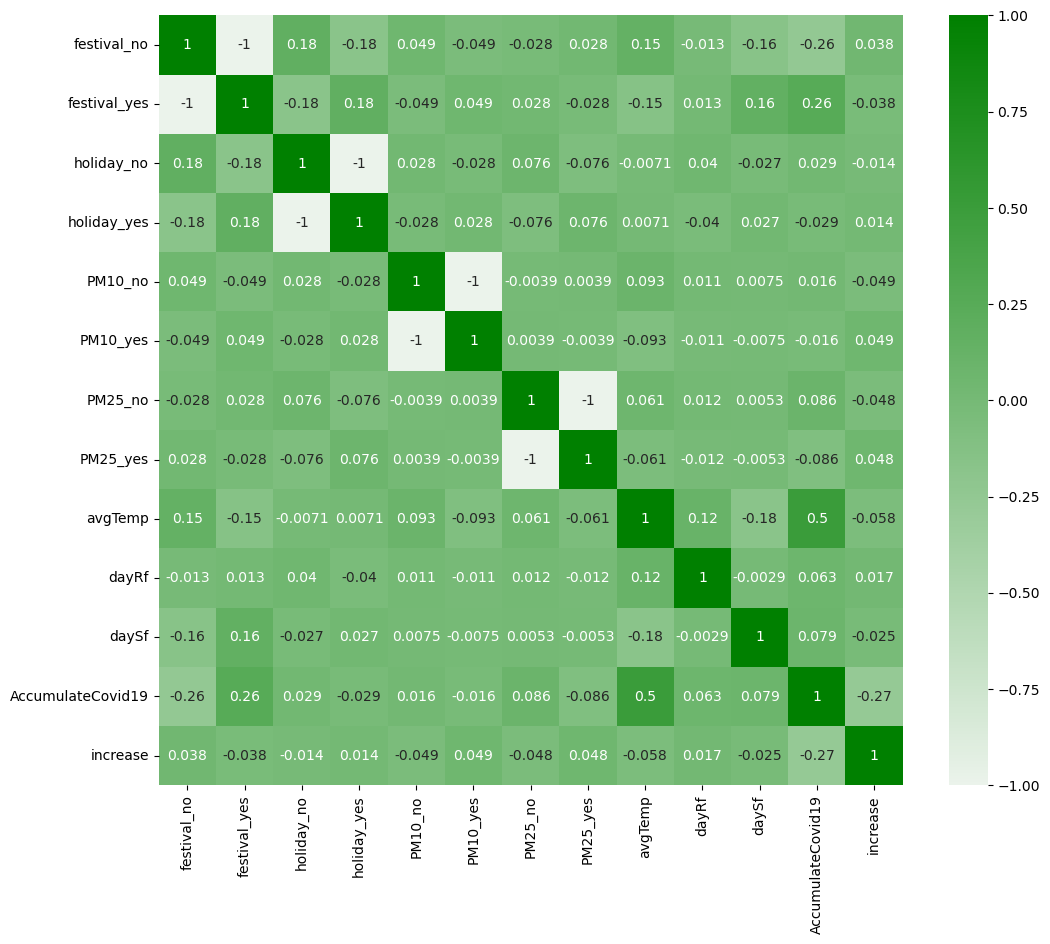

In [96]:
plt.figure(figsize=(12, 10))
cmap = sns.light_palette("green", as_cmap=True)
sns.heatmap(dfX_jeju.corr(), annot=True, cmap=cmap)
plt.show()

In [97]:
# 제주특별자치도 다중공선성 조사
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(dfX_seoul.values, i) for i in range(dfX_jeju.shape[1])]
vif["변수"] = dfX_jeju.columns
vif = vif.sort_values("VIF").reset_index(drop=True)
vif

,VIF,변수
0,1.069201,dayRf
1,1.096345,increase
2,1.229156,daySf
3,1.344920,AccumulateCovid19
4,1.536574,avgTemp
5,inf,festival_no
6,inf,festival_yes
7,inf,holiday_no
8,inf,holiday_yes
9,inf,PM10_no


In [98]:
# 학습용 7 : 검증용 3 dayRf + daySf + festival_no + festival_yes + holiday_no + holiday_yes + PM10_no + PM10_yes + PM25_no + PM25_yes + avgTemp + AccumulateCovid19 + increase
def get_model1(seed):
    df_train_jeju, df_test_jeju = train_test_split(df_jeju, test_size=0.3, random_state=seed)
    model1_jeju = sm.OLS.from_formula("touNum ~ " + "+".join(dfX_jeju.columns), data = df_train_jeju)
    return df_train_jeju, df_test_jeju, model1_jeju.fit()

df_train_jeju, df_test_jeju, result_jeju = get_model1(3)
result_jeju.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     13.63
Date:                Tue, 28 Mar 2023   Prob (F-statistic):           1.08e-17
Time:                        12:37:53   Log-Likelihood:                -2962.9
No. Observations:                 255   AIC:                             5946.
Df Residuals:                     245   BIC:                             5981.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5.648e+04   5774.242      9.782      0.000    4.51e+04    6.79e+04
festival_no        2.911e+04   3521.837      8.265      0.000    2.22e+04     3.6e+04
festival_yes       2.737e+04   3885.802      7.045      0.000    1.97e+04     3.5e+04
holiday_no         2.653e+04   3582.344      7.406      0.000    1.95e+04    3.36e+04
holiday_yes        2.995e+04   3346.961      8.949      0.000    2.34e+04    3.65e+04
PM10_no            3.664e+04   8586.832      4.267      0.000    1.97e+04    5.36e+04
PM10_yes           1.984e+04   1.17e+04      1.695      0.091   -3219.471    4.29e+04
PM25_no            1.725e+04   1.18e+04      1.465      0.144   -5949.358    4.04e+04
PM25_yes           3.923e+04   1.63e+04      2.411      0.017    7178.800    7.13e+04
avgTemp            2389.0662    261.694      9.129      0.000    1873.608    2904.524
dayRf              -393.4758    121.780     -3.231      0.001    -633.346    -153.606
daySf             -2948.8192   9407.168     -0.313      0.754   -2.15e+04    1.56e+04
AccumulateCovid19    -0.0726      0.019     -3.837      0.000      -0.110      -0.035
increase             -3.9637      1.408     -2.815      0.005      -6.738      -1.190
==============================================================================
Omnibus:                       34.635   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              227.696
Skew:                          -0.146   Prob(JB):                     3.60e-50
Kurtosis:                       7.620   Cond. No.                     4.48e+22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.54e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [99]:
# 미세먼지 제거 + PM10_no + PM10_yes + PM25_no + PM25_yes 
def get_model1(seed):
    df_train_jeju, df_test_jeju = train_test_split(df_jeju, test_size=0.3, random_state=seed)
    model1_jeju = sm.OLS.from_formula("touNum ~ dayRf + daySf + festival_no + festival_yes + holiday_no + holiday_yes + avgTemp + AccumulateCovid19 + increase", data = df_train_jeju)
    return df_train_jeju, df_test_jeju, model1_jeju.fit()

df_train_jeju, df_test_jeju, result_jeju = get_model1(3)
result_jeju.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     17.37
Date:                Tue, 28 Mar 2023   Prob (F-statistic):           1.16e-18
Time:                        12:38:05   Log-Likelihood:                -2963.6
No. Observations:                 255   AIC:                             5943.
Df Residuals:                     247   BIC:                             5972.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          8.343e+04   2552.281     32.687      0.000    7.84e+04    8.85e+04
dayRf              -393.3195    121.625     -3.234      0.001    -632.874    -153.765
daySf             -2614.8340   9385.283     -0.279      0.781   -2.11e+04    1.59e+04
festival_no        4.269e+04   2314.250     18.448      0.000    3.81e+04    4.73e+04
festival_yes       4.073e+04   2947.095     13.821      0.000    3.49e+04    4.65e+04
holiday_no         3.992e+04   2242.627     17.799      0.000    3.55e+04    4.43e+04
holiday_yes        4.351e+04   2346.509     18.542      0.000    3.89e+04    4.81e+04
avgTemp            2405.1336    259.405      9.272      0.000    1894.207    2916.061
AccumulateCovid19    -0.0740      0.019     -3.921      0.000      -0.111      -0.037
increase             -4.0053      1.403     -2.856      0.005      -6.768      -1.243
==============================================================================
Omnibus:                       34.319   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              220.950
Skew:                          -0.154   Prob(JB):                     1.05e-48
Kurtosis:                       7.550   Cond. No.                     2.20e+22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.55e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [100]:
# 공휴일 제거 + holiday_no + holiday_yes 
def get_model1(seed):
    df_train_jeju, df_test_jeju = train_test_split(df_jeju, test_size=0.3, random_state=seed)
    model1_jeju = sm.OLS.from_formula("touNum ~ dayRf + daySf + festival_no + festival_yes + PM10_no + PM10_yes + PM25_no + PM25_yes + avgTemp + AccumulateCovid19 + increase", data = df_train_jeju)
    return df_train_jeju, df_test_jeju, model1_jeju.fit()

df_train_jeju, df_test_jeju, result_jeju = get_model1(3)
result_jeju.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     15.25
Date:                Tue, 28 Mar 2023   Prob (F-statistic):           3.84e-18
Time:                        12:38:16   Log-Likelihood:                -2963.3
No. Observations:                 255   AIC:                             5945.
Df Residuals:                     246   BIC:                             5977.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          6.823e+04   6907.397      9.878      0.000    5.46e+04    8.18e+04
dayRf              -401.6142    121.386     -3.309      0.001    -640.703    -162.525
daySf             -2645.3741   9397.055     -0.282      0.779   -2.12e+04    1.59e+04
festival_no         3.45e+04   3962.588      8.705      0.000    2.67e+04    4.23e+04
festival_yes       3.374e+04   4286.714      7.870      0.000    2.53e+04    4.22e+04
PM10_no            4.223e+04   8426.256      5.012      0.000    2.56e+04    5.88e+04
PM10_yes             2.6e+04   1.21e+04      2.147      0.033    2151.035    4.99e+04
PM25_no              2.2e+04   1.13e+04      1.940      0.054    -338.321    4.43e+04
PM25_yes           4.623e+04   1.67e+04      2.770      0.006    1.34e+04    7.91e+04
avgTemp            2421.0138    259.117      9.343      0.000    1910.643    2931.384
AccumulateCovid19    -0.0754      0.019     -4.040      0.000      -0.112      -0.039
increase             -3.9337      1.407     -2.795      0.006      -6.706      -1.162
==============================================================================
Omnibus:                       33.916   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              219.306
Skew:                          -0.128   Prob(JB):                     2.39e-48
Kurtosis:                       7.536   Cond. No.                     2.34e+22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.12e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [101]:
# 코로나 제거 + AccumulateCovid19 + increase
def get_model1(seed):
    df_train_jeju, df_test_jeju = train_test_split(df_jeju, test_size=0.3, random_state=seed)
    model1_jeju = sm.OLS.from_formula("touNum ~ dayRf + daySf + holiday_no + holiday_yes + festival_no + festival_yes+ PM10_no + PM10_yes + PM25_no + PM25_yes + avgTemp", data = df_train_jeju)
    return df_train_jeju, df_test_jeju, model1_jeju.fit()

df_train_jeju, df_test_jeju, result_jeju = get_model1(3)
result_jeju.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     13.98
Date:                Tue, 28 Mar 2023   Prob (F-statistic):           2.99e-15
Time:                        12:38:31   Log-Likelihood:                -2972.1
No. Observations:                 255   AIC:                             5960.
Df Residuals:                     247   BIC:                             5989.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     5.162e+04   5828.543      8.857      0.000    4.01e+04    6.31e+04
dayRf         -403.0900    125.712     -3.206      0.002    -650.694    -155.486
daySf        -9350.4224   9539.459     -0.980      0.328   -2.81e+04    9438.638
holiday_no    2.314e+04   3606.839      6.415      0.000     1.6e+04    3.02e+04
holiday_yes   2.848e+04   3402.694      8.371      0.000    2.18e+04    3.52e+04
festival_no   2.986e+04   3547.086      8.417      0.000    2.29e+04    3.68e+04
festival_yes  2.177e+04   3762.535      5.785      0.000    1.44e+04    2.92e+04
PM10_no       3.697e+04   8865.257      4.171      0.000    1.95e+04    5.44e+04
PM10_yes      1.465e+04    1.2e+04      1.219      0.224   -9012.107    3.83e+04
PM25_no       1.387e+04   1.21e+04      1.145      0.253   -9993.914    3.77e+04
PM25_yes      3.775e+04   1.68e+04      2.252      0.025    4731.152    7.08e+04
avgTemp       1864.0401    225.578      8.263      0.000    1419.739    2308.341
==============================================================================
Omnibus:                       30.257   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              173.793
Skew:                          -0.039   Prob(JB):                     1.83e-38
Kurtosis:                       7.044   Cond. No.                     1.41e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.95e-34. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [102]:
# 날씨 제거 + avgTemp + dayRf + daySf
def get_model1(seed):
    df_train_jeju, df_test_jeju = train_test_split(df_jeju, test_size=0.3, random_state=seed)
    model1_jeju = sm.OLS.from_formula("touNum ~ holiday_no + holiday_yes + festival_no + festival_yes+ PM10_no + PM10_yes + PM25_no + PM25_yes + AccumulateCovid19 + increase", data = df_train_jeju)
    return df_train_jeju, df_test_jeju, model1_jeju.fit()

df_train_jeju, df_test_jeju, result_jeju = get_model1(3)
result_jeju.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     3.295
Date:                Tue, 28 Mar 2023   Prob (F-statistic):            0.00388
Time:                        12:38:41   Log-Likelihood:                -3004.9
No. Observations:                 255   AIC:                             6024.
Df Residuals:                     248   BIC:                             6049.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5.617e+04   6765.780      8.303      0.000    4.28e+04    6.95e+04
holiday_no         2.372e+04   4182.991      5.670      0.000    1.55e+04     3.2e+04
holiday_yes        3.246e+04   3908.141      8.305      0.000    2.48e+04    4.02e+04
festival_no        3.667e+04   4014.870      9.132      0.000    2.88e+04    4.46e+04
festival_yes       1.951e+04   4440.725      4.393      0.000    1.08e+04    2.83e+04
PM10_no            4.603e+04   9975.775      4.614      0.000    2.64e+04    6.57e+04
PM10_yes           1.015e+04   1.37e+04      0.743      0.458   -1.67e+04     3.7e+04
PM25_no            2.314e+04   1.38e+04      1.679      0.094   -4004.236    5.03e+04
PM25_yes           3.303e+04   1.91e+04      1.734      0.084   -4493.308    7.06e+04
AccumulateCovid19     0.0164      0.018      0.891      0.374      -0.020       0.053
increase             -2.9223      1.643     -1.779      0.076      -6.158       0.313
==============================================================================
Omnibus:                       33.122   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.049
Skew:                           0.389   Prob(JB):                     1.05e-30
Kurtosis:                       6.520   Cond. No.                     9.52e+22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.89e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [137]:
# 축제 제거  + festival_no + festival_yes  
def get_model1(seed):
    df_train_jeju, df_test_jeju = train_test_split(df_jeju, test_size=0.3, random_state=seed)
    model1_jeju = sm.OLS.from_formula("touNum ~ holiday_no + holiday_yes + avgTemp + dayRf + daySf + PM10_no + PM10_yes + PM25_no + PM25_yes + AccumulateCovid19 + increase", data = df_train_jeju)
    return df_train_jeju, df_test_jeju, model1_jeju.fit()

df_train_jeju, df_test_jeju, result_jeju = get_model1(3)
result_jeju.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     15.37
Date:                Tue, 28 Mar 2023   Prob (F-statistic):           2.81e-18
Time:                        15:58:38   Log-Likelihood:                -2963.0
No. Observations:                 255   AIC:                             5944.
Df Residuals:                     246   BIC:                             5976.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          6.804e+04   6882.058      9.886      0.000    5.45e+04    8.16e+04
holiday_no         3.248e+04   3996.038      8.128      0.000    2.46e+04    4.03e+04
holiday_yes        3.556e+04   3826.783      9.292      0.000     2.8e+04    4.31e+04
avgTemp            2420.4306    247.350      9.785      0.000    1933.237    2907.624
dayRf              -394.2237    121.550     -3.243      0.001    -633.636    -154.811
daySf             -3218.4175   9362.863     -0.344      0.731   -2.17e+04    1.52e+04
PM10_no             4.25e+04   8396.872      5.061      0.000     2.6e+04     5.9e+04
PM10_yes           2.554e+04   1.21e+04      2.110      0.036    1697.525    4.94e+04
PM25_no            2.283e+04   1.14e+04      2.008      0.046     437.388    4.52e+04
PM25_yes           4.521e+04   1.67e+04      2.704      0.007    1.23e+04    7.81e+04
AccumulateCovid19    -0.0754      0.017     -4.329      0.000      -0.110      -0.041
increase             -3.9821      1.405     -2.834      0.005      -6.749      -1.215
==============================================================================
Omnibus:                       33.883   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              216.100
Skew:                          -0.142   Prob(JB):                     1.19e-47
Kurtosis:                       7.501   Cond. No.                     1.55e+22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.13e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [119]:
# 조정된 R 값이 상승하는 변수만 삭제 
def get_model1(seed):
    df_train_jeju, df_test_jeju = train_test_split(df_jeju, test_size=0.3, random_state=seed)
    model1_jeju = sm.OLS.from_formula("touNum ~ avgTemp + dayRf + AccumulateCovid19 + increase", data = df_train_jeju)
    return df_train_jeju, df_test_jeju, model1_jeju.fit()

df_train_jeju, df_test_jeju, result_jeju = get_model1(3)
result_jeju.summary()

# 영향력이 없는 변수들 holiday_no + holiday_yes + daySf + festival_no + festival_yes + PM10_no + PM10_yes + PM25_no + PM25_yes + 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     30.39
Date:                Tue, 28 Mar 2023   Prob (F-statistic):           1.29e-20
Time:                        12:44:33   Log-Likelihood:                -2964.1
No. Observations:                 255   AIC:                             5938.
Df Residuals:                     250   BIC:                             5956.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.668e+05   4828.073     34.556      0.000    1.57e+05    1.76e+05
avgTemp            2471.3952    234.342     10.546      0.000    2009.860    2932.931
dayRf              -402.3492    120.783     -3.331      0.001    -640.231    -164.468
AccumulateCovid19    -0.0795      0.017     -4.742      0.000      -0.112      -0.046
increase             -3.9904      1.394     -2.862      0.005      -6.737      -1.244
==============================================================================
Omnibus:                       33.057   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              204.553
Skew:                          -0.134   Prob(JB):                     3.82e-45
Kurtosis:                       7.380   Cond. No.                     7.32e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.32e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [56]:
# 교차 검증
scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(dfXy_jeju)):
    df_train = df.iloc[idx_train]
    df_test = df.iloc[idx_test]

    model = sm.OLS.from_formula("touNum ~" + "+".join(dfX_jeju.columns), data=df_jeju)
    result = model.fit()

    pred = result.predict(df_test)
    rss = ((df_test.touNum - pred) ** 2).sum()
    tss = ((df_test.touNum - df_test.touNum.mean()) ** 2).sum()
    rsquared = 1 - rss / tss

    scores[i] = rsquared
    print(f"학습용 R2 = {result.rsquared:.3f}, 검증용 R2 = {result.rsquared:.3f}")

학습용 R2 = 0.318, 검증용 R2 = 0.318
학습용 R2 = 0.318, 검증용 R2 = 0.318
학습용 R2 = 0.318, 검증용 R2 = 0.318
학습용 R2 = 0.318, 검증용 R2 = 0.318
학습용 R2 = 0.318, 검증용 R2 = 0.318


시계열분석 및 모델링

In [55]:
# 데이터 분할
X = df_jeju['increase'].values.reshape(-1, 1) # 독립 변수
y = df_jeju['touNum'].values.reshape(-1, 1) # 종속 변수
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 훈련
model = LinearRegression()
model.fit(X_train, y_train)

# 모델 평가
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}')

# 미래 예측
future_confirmed = [[100], [200], [300]]
future_tourists = model.predict(future_confirmed)
    

MAE: 24467.20, RMSE: 31390.45


- ARIMA (자기회귀모델, AutoRegressive Model)

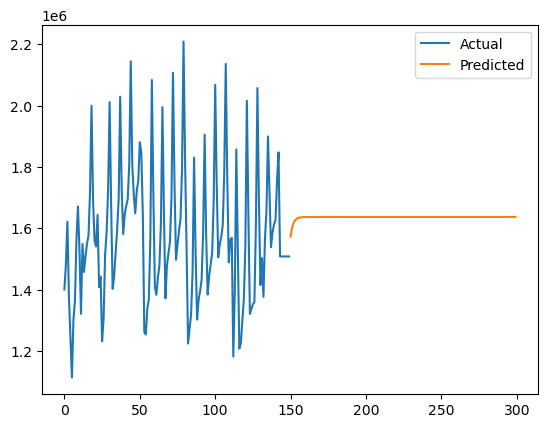

In [ ]:
# 날짜를 인덱스로
# df_seoul['baseYmd'] = pd.to_datetime(df_seoul['baseYmd'])
# df_seoul = df_seoul.set_index('baseYmd')

# 마지막 30일을 검증용 데이터로 사용
train_data = df_seoul.iloc[:-215]
test_data = df_seoul.iloc[-150:]

model = ARIMA(train_data['touNum'], order=(1,1,1))
model_fit = model.fit()

# 검증용 데이터를 활용하여 예측
predictions = model_fit.forecast(steps=len(test_data))

# 예측결과 시각화
plt.plot(test_data['touNum'].values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [ ]:
# 함수로 만들기

def arima_analysis(data_path, column_name, city, order=(1,1,1), test_size=365):
    # 불러올 데이터
    df = pd.read_csv(data_path, parse_dates=['baseYmd'])
    data_df = df.loc[df['areaNm'] == city]
    # 날짜 인덱스 설정
    data_df = data_df.set_index('baseYmd')
    train_data = data_df.iloc[:-test_size]
    test_data = data_df.iloc[-test_size:]
    # 학습용 모델 Train ARIMA model
    model = ARIMA(train_data[column_name], order=order)
    model_fit = model.fit()
    # 예측값 생성
    predictions = model_fit.forecast(steps=len(test_data))
    # 시각화
    plt.plot(test_data[column_name].values, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title(f'{column_name} Forecasting with ARIMA Model')
    plt.xlabel('baseYmd')
    plt.ylabel(column_name)
    plt.legend()
    plt.show()


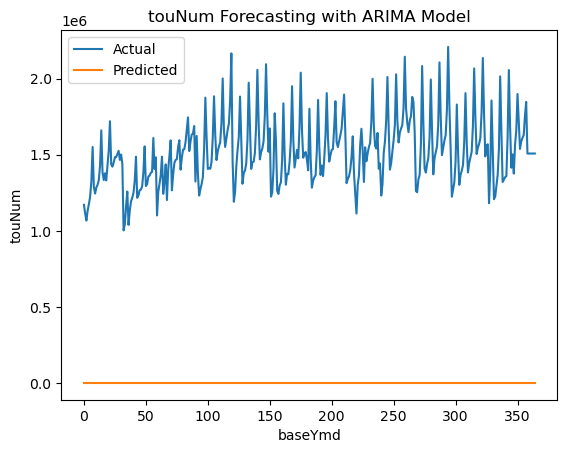

In [ ]:
arima_analysis('./data/df_final.csv', 'touNum', '서울특별시')